In [3]:
# Transform and analysis the Data for Yellow Taxi trips for the Month of Janaury 2024 #
# Release Version 1.0, 2024-10-01# 
# Author:Lakshmi Priya #

import pandas as pd
import pyarrow.parquet as pq
from google.cloud import bigquery
import pyarrow
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/lravin667/Downloads/decisive-scion-437014-c8-d5fd4b94b067.json'
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns

"""
To Transform the data to calculate the below additional fields,
   1. Trip Duration  - To get the duration of each trip in minutes/seconds
   2. Fare Amount    - Calculate the fare amount per mile to analyse price trends
   3. Flag           - Value of High for trips with unusually high fares or long distances for further investigation
   4. Total Fare     - Calculate the total fare of the trip
   5. Total surcharges- Aggregate various surcharge amounts
   6. Day/night ind  - Calcaute the indicator, 
                       if the hour of trip is between 6 AM to 18 PM its marked as "Day"
                       if the hour of trip is between 18 PM to 6 AM its marked as "Night"
   7. Weekday        - calculate the weekday when the trip was taken.
                    0 -'Monday', 1-'Tuesday', 2 -'Wednesday', 3-'Thursday', 4-'Friday', 5-'Saturday', 6-'Sunday'
   8. Rush hour     - calculate the rush hour indicator 
                      if the hour of trip is between 7 AM to 9 AM or 16 PM to 19 PM its marked as "Yes"
                      if the hour of trip is between 9 AM to 16 PM or 19 PM to 7 AM its marked as "No"
   9. Daily Summary - Calculate the daily summary of data for the month of January on the following columns,
                      Total distance covered on all trips on the given day
                      Total amount earned on the day
                      Passengar count on the given day
 
"""
def transform(gcs_parquet_file_path):
    # Read the Parquet file into a pandas DataFrame
    df = pd.read_parquet(gcs_parquet_file_path)

    #1 Calculate Trip Duration

    df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    #trip_duration=df['trip_duration']
    #print(trip_duration)
    
    #2 Calculate fare per mile
    df['fare_per_mile'] = df['fare_amount'] / df['trip_distance'].replace(0, 1)  # Avoid division by zero
    #fare_per_mile=df['fare_per_mile']
    #print(fare_per_mile)

    #3 mark the high fare trips 
    q1 = df['trip_distance'].quantile(0.25)
    q3 = df['trip_distance'].quantile(0.75)
    iqr = q3 - q1
    df['high_fare_trips'] = ((df['trip_distance'] >= (q1 - 1.5 * iqr)) & (df['trip_distance'] <= (q3 + 1.5 * iqr))).astype(int)
    df['high_fare_trips']=df['high_fare_trips'].replace({0:'High',1:'Low'})
    
    #4 Calculate the Total fare of the trip
    df['total_fare'] = df[['fare_amount', 'tip_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].sum(axis=1)

    #5 Calculate total surcharge
    df['total_surcharge'] = df[['extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']].sum(axis=1)

    #6 To calculate Day/night indicator
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['day_night_trip'] = df['pickup_hour'].apply(lambda x: 'Day'if 6 <= x <= 18 else'Night')

    #7 To calculate the Week day of the trip
    df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek

    #8 To calculate the rush hour 
    df['rush_hour'] = df['pickup_hour'].apply(lambda x: 'Yes'if (7 <= x <= 9) or (16 <= x <= 19) else 'No')

    #9 daily summary
    daily_summary = df.groupby(df['tpep_pickup_datetime'].dt.date).agg({
    'trip_distance': 'sum',
    'total_amount': 'sum',
    'passenger_count': 'sum'
        }).reset_index()

    return df

def calc_daily_summary(df):

    # Calculate daily summary
    daily_summary = df.groupby(df['tpep_pickup_datetime'].dt.date).agg({
        'trip_distance': 'sum',
        'total_amount': 'sum',
        'passenger_count': 'sum'
    }).reset_index()
    print('Daily Summary of Trip data For Janaury')
    print(daily_summary)
    
    
def load_parquet_to_partitioned_bigquery(dataset_id, table_id, df, partition_column):
    # Initialize the BigQuery client
    client = bigquery.Client()

    # Create a job configuration for loading the Parquet file
    job_config = bigquery.LoadJobConfig(
        source_format=bigquery.SourceFormat.PARQUET,
        # Specify partitioning
        time_partitioning=bigquery.TimePartitioning(
            field=partition_column,  # The column to partition by
            type_=bigquery.TimePartitioningType.DAY,  # Partitioning type (DAY, MONTH, YEAR)
        ),
    )

    # Load the data into the partitioned BigQuery table
    load_job = client.load_table_from_dataframe(
        df,
        f'{client.project}.{dataset_id}.{table_id}'
    )

    # Wait for the job to complete
    load_job.result()

    # Output the result
    print(f'Loaded {load_job.output_rows} rows into {dataset_id}.{table_id}.')


if __name__ == '__main__':
    
    gcs_parquet_file_path ='gs://lakshmi_test1/yellow_tripdata_2024-01.parquet'  

    #Transform the input dataset
    df=transform(gcs_parquet_file_path)

    # Load the dataset into a table 
    dataset_id = 'yellow_tripdata'  # dataset ID
    table_id = 'yellow_trip_xref_table'       # table ID
    partition_column='VendorID'  #partition column on which table will be partitioned

    #load_parquet_to_partitioned_bigquery(dataset_id, table_id, df,partition_column)

    #Generate Daily summary
    #calc_daily_summary(df)


# Exploratory Data Analysis of Cab Trip Data

## Key Insights

### 1. Distribution of Passenger Count and calculate the average fare
The passenger count distribution shows that most trips have 1-2 passengers, with very few trips having more than 4 passengers along with average fare amount by passengar count

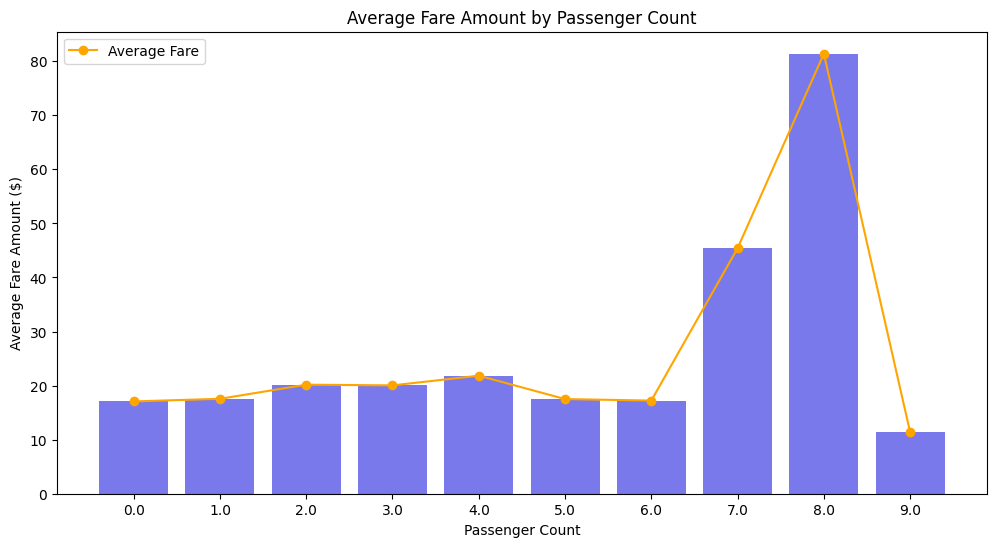

In [4]:
# Group by passenger count and calculate average fare
avg_fare = df.groupby('passenger_count')['fare_amount'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='passenger_count', y='fare_amount', data=avg_fare, color='blue', alpha=0.6)
plt.title('Average Fare Amount by Passenger Count')

# Add a line plot for better trend visibility
plt.plot(avg_fare['passenger_count'], avg_fare['fare_amount'], color='orange', marker='o', label='Average Fare')
plt.xlabel('Passenger Count')
plt.ylabel('Average Fare Amount ($)')
plt.legend()
plt.show()

### 2. Distribution of average fare amount based on pickup times
The average fare anouunt based on pick up hour and also the variations based on pick up day of the week.

/var/folders/_m/fgr4n_zn03lfff_k_lplxdfh0000gn/T/ipykernel_4595/860274249.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(data=summary_data, x='pickup_hour', y='pickup_count', hue='pickup_day_of_week', palette='muted', alpha=0.6)
/var/folders/_m/fgr4n_zn03lfff_k_lplxdfh0000gn/T/ipykernel_4595/860274249.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')


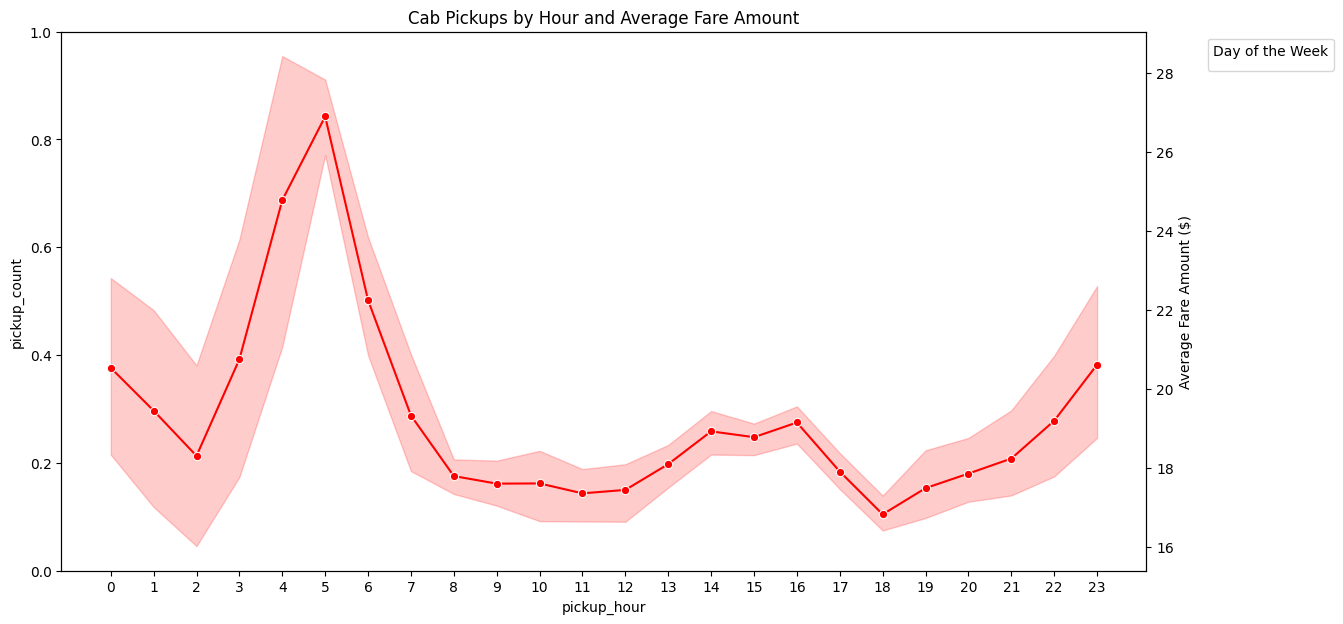

In [5]:
# Group by pickup day and hour to get counts
pickup_counts = df.groupby(['pickup_day_of_week', 'pickup_hour']).size().reset_index(name='pickup_count')

# Optionally, calculate average fare amount per day and hour
avg_fare = df.groupby(['pickup_day_of_week', 'pickup_hour'])['fare_amount'].mean().reset_index(name='avg_fare')

# Merge the two DataFrames
summary_data = pd.merge(pickup_counts, avg_fare, on=['pickup_day_of_week', 'pickup_hour'])

# Order days of the week for better visualization
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
summary_data['pickup_day_of_week'] = pd.Categorical(summary_data['pickup_day_of_week'], categories=day_order, ordered=True)

# Create the plot
plt.figure(figsize=(14, 7))

# Bar plot for pickup count
sns.barplot(data=summary_data, x='pickup_hour', y='pickup_count', hue='pickup_day_of_week', palette='muted', alpha=0.6)

# Line plot for average fare amount
# Note: You might want to scale this line or use a secondary axis for better visibility.
ax2 = plt.gca().twinx()
sns.lineplot(data=summary_data, x='pickup_hour', y='avg_fare', color='red', marker='o', ax=ax2)

# Customize the axes
plt.title('Cab Pickups by Hour and Average Fare Amount')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Pickups')
ax2.set_ylabel('Average Fare Amount ($)')

# Show legend
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()